#Create a study assistant application capable of helping the candidates in various phases of their preparation to achieve their goals



Install the necessary libraries

In [3]:
%%capture --no-stderr
%pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core faiss-cpu  langchain-openai langchain-community
%pip install ipython

In [4]:
import getpass
import os

# Load environment variables from a .env file
from google.colab import userdata
os.environ["OPENAI_API_KEY"]=userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"]=userdata.get('TAVILY_API_KEY')

## Langsmith tracking
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_API_KEY"]=userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_PROJECT"]="Binary Search Trees with Web search Capability"

In [5]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

In [6]:
%pip install -q pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.5/294.5 kB 15.8 MB/s eta 0:00:00


In [7]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.embeddings.openai import OpenAIEmbeddings
indexName="BinarySearchTrees"

In [ ]:
loader = PyPDFLoader("data/BinarySearchTrees.pdf")
documents=loader.load()
text_splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=100)
final_documents=text_splitter.split_documents(documents)
embeddings=OpenAIEmbeddings()
vecStore=FAISS.from_documents(final_documents,embeddings)
# Save the vector DB to your local
db =vecStore.save_local(folder_path="Database", index_name=indexName)

In [8]:
db=FAISS.load_local(folder_path="Database", index_name=indexName, embeddings=OpenAIEmbeddings(),allow_dangerous_deserialization=True)

<ipython-input-8-cc81e16259f7>:1: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  db=FAISS.load_local(folder_path="Database", index_name=indexName, embeddings=OpenAIEmbeddings(),allow_dangerous_deserialization=True)


In [9]:
from langchain.tools.retriever import create_retriever_tool
retriever=db.as_retriever()
#retriever_tool=create_retriever_tool(retriever,"BinarySearchTreesBook", "This contains information about binary search tree concepts. Use this to create a study plan.")

In [10]:
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model_name="gpt-4o")
llm

ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7e1db144eb30>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7e1db129cc70>, root_client=<openai.OpenAI object at 0x7e1db3e79f60>, root_async_client=<openai.AsyncOpenAI object at 0x7e1db144eb90>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********'))

##Step 1: Create a routing logic
This step contains a question router chain that combines the LLM with the prompt and structures the output which returns whether the question requires an RAG context or a web search to generate an answer. Review the code below and It returns “vectorstore” or “web_search”.

In [12]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to Introduction of Binary search tree, red black trees and AVL trees.
Use the vectorstore for questions on these topics to create study plan, notes, cheat sheet, preparation materials for each concept.
Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

In [30]:

def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


##Step 2: Web search tool
Tavily Web search tool is one of the tools used in langchain community.

In [13]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

## Step 3: Create a chain to generate the answers
Create a rag_chain which is a combination of LLM+ prompt template+ output parser. OutputParser that parses LLMResult into the top likely string. Prompt Template is one of the templates that is in the lang chain hub.

In [11]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()



## Step 4 Construct the Graph
Capture the flow in as a graph.

Define Graph State

In [14]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

## Step 5: Retrieve from the database and generate answers
The following code generates based on the documents that are retrieved from the db retriever. The retriever uses a Maximum marginal relevance retrieval mechanism to retrieve the documents.

In [29]:
def generatevecDB(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---RETRIEVE---")
    question = state["question"]
    documents = retriever.invoke(question)
    print("---GENERATE---")
    question = state["question"]
    state["documents"] =documents

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}



## Step 6: Web search tool invocation
Invoke the web search tool with the questions. The "documents" context will be None as this does not correspond to the RAG

In [ ]:
from langchain.schema import Document
def web_search(state):
    """
    Web search based on the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": None , "question": question,"generation": web_results}

## Step 7: Graph design
The start invokes route_question where the question is classified as a vectorStore or web_search. Based on the result it invokes either the vectorstore node or web_search node. which ends the workflow after generating the results.

In [31]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("vectorstore", generatevecDB)  # generatae

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "vectorstore",
    },
)
workflow.add_edge("web_search",END)
workflow.add_edge("vectorstore", END)

# Compile
app = workflow.compile()

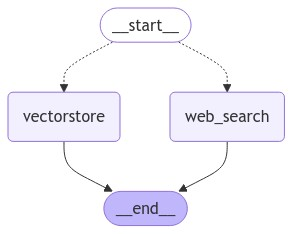

In [32]:

from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("Something happened")
    pass

In [26]:
from pprint import pprint


In [33]:
questionprompts={
    1: "Give me a brief note on AVL trees?",
    2: "Tutor me about binary search trees in 300 words. ",
    3: "Give me 2 MCQ's interview questions along with 4 options in Binary Search tree topic from the web. State the correct answer. Let the difficulty level be Easy",
}

## Step 8: Queries

In [34]:
# Run
answers = {}
for qkey, qq in questionprompts.items():
  inputs = {"question": qq}
  print("Question: "+ qq)
  for output in app.stream(inputs,{"recursion_limit": 100}):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        pprint("Value: "+str(value))
    pprint("\n---\n")
  print("Key:"+ str(key))
  answers[qkey] = value["generation"]
  # Final generation
  pprint(value["generation"])


Question: Give me a brief note on AVL trees?
---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---GENERATE---
"Node 'vectorstore':"
("Value: {'question': 'Give me a brief note on AVL trees?', 'generation': 'An "
 'AVL tree is a self-balancing binary search tree where the heights of the two '
 'child subtrees of any node differ by at most one. This property helps '
 'maintain a balanced tree structure, ensuring efficient search, insertion, '
 'and deletion operations. AVL trees are named after their inventors, '
 "Adelson-Velsky and Landis.', 'documents': [Document(metadata={'source': "
 "'data/BinarySearchTrees.pdf', 'page': 4}, page_content='12.1  What  is a "
 'binary  search  tree?  313 \\n5 2 5 5 \\n8 7 6 \\n(a) 6 8 7 5 2 \\n(b) 6 '
 '\\n5 7 \\n2 5 8 2 \\n5 \\n7 \\n6 8 \\n5 T: root T: root \\nFigure  12.1  '
 'Binary search trees. For any node x, the keys in the left subtree of x are '
 'at most x: key, \\nand the keys in the right subtree of x are at least x: '
 'key

In [63]:
# Run
inputs = {
    "question": "Give me a brief note on Red black trees?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
        pprint(value)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---GENERATE---
"Node 'vectorstore':"
{'documents': [Document(metadata={'source': 'data/BinarySearchTrees.pdf', 'page': 25}, page_content='red-black  tree?  What  if it is colored  black?  \n13.1-3  \nDeûne  a relaxed  red-black  tree  as a binary  search  tree  that  satisûes  red-black  prop-  \nerties  1, 3, 4, and  5, but  whose  root  may  be either  red  or black.  Consider a relaxed \nred-black  tree  T whose root is red. If the root of T is changed to black but no other \nchanges  occur,  is the  resulting  tree  a red-black  tree?'),
               Document(metadata={'source': 'data/BinarySearchTrees.pdf', 'page': 23}, page_content='332  Chapter  13  Red-Black  Trees  \n4. If a node  is red,  then  both  its  children  are  black.  \n5. For  each  node,  all  simple  paths  from  the  node  to descendant  leaves contain the \nsame number of black nodes. \nFigure  13.1(a)  shows  an example  of a red-black  tree.  \